# Guide to Extracting Data w/ APIs from the Whoop Strap 4.0

<img src="https://images.ctfassets.net/rbzqg6pelgqa/3CL3kZerAu072z1zr7jEYp/fa9fdf30e007201f03a645e3295f8c0f/introducing-4-0-whoop-body-any-wear-technology-en.jpg" width="500"/>

As Kanye once [said](https://www.youtube.com/watch?v=8fbyfDbi-MI),

> Scoop-diddy-whoop
> >
> Whoop-diddy-scoop

While we certainly won't be rapping in this notebook, we will be using the [WHOOP 4.0](https://www.whoop.com/membership/strap/), a small wearable that fits onto your wrist as shown above! Featuring a light, discreet wristband that is also waterproof, the WHOOP 4.0 offers comfortable [physical activity](https://github.com/alrojo/wearipedia/tree/main/metrics/physical-activity) and [sleep](https://github.com/alrojo/wearipedia/tree/main/metrics/sleep) tracking with wireless charging and an app with useful calculated metrics such as strain and recovery. 

We've used the WHOOP 4.0 for a while now, and we'll show you how to extract its data, visualize steep stages, and compute correlations and other statistical measures based on your data! While you will need a WHOOP 4.0 set up to actually collect the data, the data *extraction* requires only an internet connection and your username and password.

This is a comprehensive, clear guide to extract your data from the WHOOP 4.0 using the official WHOOP [Application Programming Interface (API)](https://developer.whoop.com/api).

We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Strain      |  Per cycle, per workout
Kilojoules (energy bruned) |  Per cycle, per workout 
Average heart rate |  Per cycle, per workout
Maximum heart rate |  Per cycle, per workout
Total in bed time |  Per sleep
Total awake time |  Per sleep
Total light sleep time |  Per sleep
Total slow wave sleep time |  Per sleep
Total REM sleep time |  Per sleep
Sleep cycle count |  Per sleep
Sleep disturbance count |  Per sleep
Baseline sleep need |  Per sleep
Sleep need from sleep debt |  Per sleep
Sleep need from recent strain |  Per sleep
Sleep need from recent nap |  Per sleep
Respiratory rate | Per sleep
Sleep perfomance percentage | Per sleep
Sleep consistency percentage | Per sleep
Sleep efficiency percentage | Per sleep
Workout distance | Per workout
Workout altitude gain | Per workout
Workout altitude change | Per workout
Workout zone zero duration | Per workout
Workout zone one duration | Per workout
Workout zone two duration | Per workout
Workout zone three duration | Per workout
Workout zone four duration | Per workout
Workout zone five duration | Per workout

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the WHOOP 4.0 API:
1. **Setup**
2. **Authentication/Authorization**
    - Requires only creating an app with your email and password.
3. **Data extraction**
    - You can get data from the API in a couple lines of code.
4. **Data visualization**
    - 4.1: We reproduce a day-by-day week-long plot of hours slept and sleep needed, which is displayed in the mobile app originally. We do this with matplotlib.
    - 4.2: We reproduce a day-by-day week-long plot of sleep performance percentage, which is displayed in the mobile app originally. We also do this with matplotlib.
5. **Data analysis**
    - 5.1: We try to find a correlation between the sleep performance and total time in bed. We find that the two are correlated
    - 5.2: We try to check whether strain is correlated to average heart rate in a day. We find that for our data this is statistically significant.


Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data.

# 1. Setup

## 1.1 Study participant setup and usage

Setting the watch up for data collection was fairly straightforward in our experience: just download the [WHOOP app](https://www.whoop.com/membership/app/) and follow the instructions there (You should be able to register a Whoop account with an email and password there). Since the watch does not connect to internet, all you need to do is connect your phone to the watch via bluetooth, and all data transfer will happen (1) between the watch and the phone via Bluetooth and (2) between the phone and Whoop's servers via Wi-Fi. The watch can store up to [3 days' worth of data](https://support.whoop.com/Connectivity/Commonly_Asked_Questions/Why_is_my_WHOOP_%22Catching_Up%22%3F), so it does not need to be connected to the phone all of the time.

## 1.2 Wearipedia Library Install
Relevant libraries are imported below. Just run the code to import all the libraries including our unique device data extractor, Wearipedia.

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from datetime import datetime
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import math

%pip install --no-cache-dir git+https://github.com/a-llison-lau/wearipedia.git

import wearipedia
device = wearipedia.get_device('whoop/whoop_4')

  Cloning https://github.com/a-llison-lau/wearipedia.git to /private/var/folders/2d/q4r8sw2j1m71lm5p7cm2ggyr0000gn/T/pip-req-build-h0jcp7s6
  Running command git clone --filter=blob:none --quiet https://github.com/a-llison-lau/wearipedia.git /private/var/folders/2d/q4r8sw2j1m71lm5p7cm2ggyr0000gn/T/pip-req-build-h0jcp7s6
  Resolved https://github.com/a-llison-lau/wearipedia.git to commit 6a8a5afc162fd6404c355989787556755c44d554
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wearipedia: filename=wearipedia-0.1.2-py3-none-any.whl size=132626 sha256=c618d54a3795f34413b1ee30343da2c2585cccaed78de6941532d7d93934b1dd
  Stored in directory: /private/var/folders/2d/q4r8sw2j1m71lm5p7cm2ggyr0000gn/T/pip-ephem-wheel-cache-22wy9et1/wheels/be/3d/65/577c8262c41d5538436d216da70a87787268cbab6202ef2e23
Successfully built wearipedia
  Attempting uninstall: wearipedia
    Found existing installation:

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. 

First, follow the steps listed below:

1. Visit the [developer portal](https://developer-dashboard.whoop.com/login) and log in with the email and password you registered when you purchased the Whoop strap.
2. Once logged in, you will be prompted to create a Team if you have not yet done so.
3. To make full use of the notebook, select all scopes.
4. Put whatever you want under "Application Name". For redirect URL, enter [https://wearipedia.com/](https://wearipedia.com/) 

In the end, you should see something like the below.

<img src="https://imgur.com/DwwaXS6.png"></img>

Now we can proceed with the rest of the notebook.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This (ephemeral) access token will serve as our key to the data. While, you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the Autho Docs](https://auth0.com/docs/get-started/authentication-and-authorization-flow/call-your-api-using-the-authorization-code-flow#prerequisites).

In [2]:
#@title 5. Enter your credentials below (from the application you just created) or enter synthetic to be True if you do not want real data
CLIENT_ID = "25c6aeb7-e1e1-4978-8130-e163ba2d7272" #@param {type:"string"}
CLIENT_SECRET = "737cd3f1d1ee5d7d481807c7ccc6dca19e0b146c70aca7bcf8ccd72d42f2e7df" #@param {type:"string"}
use_synthetic = False #@param {type:"boolean"}
credentials = {"client_id": CLIENT_ID, "client_secret": CLIENT_SECRET}
if not use_synthetic:
  device.authenticate(credentials)

----------------------------
Authorization url below. Please sign in to grant access, and copy the redirect url.
https://api.prod.whoop.com/oauth/oauth2/auth?response_type=code&client_id=25c6aeb7-e1e1-4978-8130-e163ba2d7272&redirect_uri=https://wearipedia.com/&scope=read:recovery%20read:cycles%20read:workout%20read:sleep%20read:profile%20read:body_measurement%20offline&state=fjrxpywkf
----------------------------
Enter redirect url:
Authentication succeeded.


5. If `CLIENT_ID` and `CLIENT_SECRET` are entered and `use_synthetic` is selected to be `False`, you should see an Authorization URL. Following the Authorization URL, you will be asked to grant access to specific scopes of data. To use Wearipedia, grant access, and you will be redirected back to [https://www.wearipedia.com/](https://www.wearipedia.com/). Then, copy the URL and paste into the textfield. You should see "Authentication succeeded".

# 3. Data extraction

Here, data extraction is pretty simple! 

Data can be extracted via wearipedia, our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

Please go back to step 5 of Authentication/Authorization where you can uncheck the "use_synthetic" box to instead use your own *real* data via Whoop API calls!

In [3]:
#@title Extract data via the API!
#set start and end dates - this will give you all the data from 2020-01-01 (January 1st, 2020) to 2022-12-01 (December 1st, 2022), for example
start_date='2020-01-01' #@param {type:"date"}
end_date='2022-12-01' #@param {type:"date"}
params = {"start": start_date, "end": end_date}

sleeps_df = device.get_data("sleeps", params=params) 
cycles_df = device.get_data("cycles", params=params) 

In [4]:
sleeps_df

,user_id,id,created_at,updated_at,start,end,timezone_offset,nap,score_state,score
0,16043,95521,2022-06-16T10:23:50.947000Z,2022-06-16T11:42:07.260000Z,2022-06-15T22:48:39.443000Z,2022-06-16T07:30:52.947000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
1,16043,73194,2022-06-15T04:45:40.336000Z,2022-06-15T05:48:01.511000Z,2022-06-14T21:30:27.740000Z,2022-06-15T03:39:20.336000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
2,16043,86085,2022-06-14T08:24:03.901000Z,2022-06-14T10:50:07.131000Z,2022-06-13T21:36:26.660000Z,2022-06-14T07:16:00.901000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
3,16043,27869,2022-06-13T06:53:51.959000Z,2022-06-13T07:56:30.227000Z,2022-06-12T22:01:47.191000Z,2022-06-13T04:23:33.959000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
4,16043,46159,2022-06-12T04:39:10.732000Z,2022-06-12T06:11:34.180000Z,2022-06-11T21:31:30.766000Z,2022-06-12T02:38:19.732000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
...,...,...,...,...,...,...,...,...,...,...
101,16043,37569,2022-03-07T06:42:03.241000Z,2022-03-07T09:25:25.589000Z,2022-03-06T22:05:25.301000Z,2022-03-07T03:57:25.241000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
102,16043,42419,2022-03-06T06:37:49.228000Z,2022-03-06T09:17:38.665000Z,2022-03-05T21:09:51.435000Z,2022-03-06T04:33:11.228000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
103,16043,87749,2022-03-05T10:43:46.412000Z,2022-03-05T13:10:37.747000Z,2022-03-04T22:51:11.677000Z,2022-03-05T08:34:11.412000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...
104,16043,74682,2022-03-04T06:06:35.080000Z,2022-03-04T07:23:51.474000Z,2022-03-03T21:25:38.564000Z,2022-03-04T03:50:00.080000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...


In [5]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', None)
sleeps_df

,user_id,id,created_at,updated_at,start,end,timezone_offset,nap,score_state,score
0,16043,95521,2022-06-16T10:23:50.947000Z,2022-06-16T11:42:07.260000Z,2022-06-15T22:48:39.443000Z,2022-06-16T07:30:52.947000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 29216099, 'total_awake_time_milli': 1960347, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 13390170, 'total_slow_wave_sleep_time_milli': 6388284, 'total_rem_sleep_time_milli': 7477296, 'sleep_cycle_count': 3, 'disturbance_count': 1}, 'sleep_needed': {'baseline_milli': 23810205, 'need_from_sleep_debt_milli': 105818, 'need_from_recent_strain_milli': 476930, 'need_from_recent_nap_milli': -34453}, 'respiratory_rate': 14.22, 'sleep_performance_percentage': 90, 'sleep_consistency_percentage': 89, 'sleep_efficiency_percentage': 89.21}"
1,16043,73194,2022-06-15T04:45:40.336000Z,2022-06-15T05:48:01.511000Z,2022-06-14T21:30:27.740000Z,2022-06-15T03:39:20.336000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 28090864, 'total_awake_time_milli': 1984596, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 13602668, 'total_slow_wave_sleep_time_milli': 7347071, 'total_rem_sleep_time_milli': 5156526, 'sleep_cycle_count': 3, 'disturbance_count': 4}, 'sleep_needed': {'baseline_milli': 25296892, 'need_from_sleep_debt_milli': 266434, 'need_from_recent_strain_milli': 394642, 'need_from_recent_nap_milli': -11675}, 'respiratory_rate': 12.74, 'sleep_performance_percentage': 89, 'sleep_consistency_percentage': 97, 'sleep_efficiency_percentage': 92.73}"
2,16043,86085,2022-06-14T08:24:03.901000Z,2022-06-14T10:50:07.131000Z,2022-06-13T21:36:26.660000Z,2022-06-14T07:16:00.901000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 32786993, 'total_awake_time_milli': 1822392, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 17860942, 'total_slow_wave_sleep_time_milli': 6824319, 'total_rem_sleep_time_milli': 6279338, 'sleep_cycle_count': 2, 'disturbance_count': 8}, 'sleep_needed': {'baseline_milli': 24179461, 'need_from_sleep_debt_milli': 341891, 'need_from_recent_strain_milli': 111385, 'need_from_recent_nap_milli': -21907}, 'respiratory_rate': 14.84, 'sleep_performance_percentage': 92, 'sleep_consistency_percentage': 90, 'sleep_efficiency_percentage': 92.06}"
3,16043,27869,2022-06-13T06:53:51.959000Z,2022-06-13T07:56:30.227000Z,2022-06-12T22:01:47.191000Z,2022-06-13T04:23:33.959000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 22576652, 'total_awake_time_milli': 1792129, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 10961097, 'total_slow_wave_sleep_time_milli': 3330179, 'total_rem_sleep_time_milli': 6493244, 'sleep_cycle_count': 2, 'disturbance_count': 2}, 'sleep_needed': {'baseline_milli': 24467834, 'need_from_sleep_debt_milli': 445252, 'need_from_recent_strain_milli': 466221, 'need_from_recent_nap_milli': -39}, 'respiratory_rate': 14.29, 'sleep_performance_percentage': 82, 'sleep_consistency_percentage': 91, 'sleep_efficiency_percentage': 89.47}"
4,16043,46159,2022-06-12T04:39:10.732000Z,2022-06-12T06:11:34.180000Z,2022-06-11T21:31:30.766000Z,2022-06-12T02:38:19.732000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 26754951, 'total_awake_time_milli': 1167493, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 13802983, 'total_slow_wave_sleep_time_milli': 5445513, 'total_rem_sleep_time_milli': 6338960, 'sleep_cycle_count': 1, 'disturbance_count': 7}, 'sleep_needed': {'baseline_milli': 25292872, 'need_from_sleep_debt_milli': 192691, 'need_from_recent_strain_milli': 232145, 'need_from_recent_nap_milli': -17886}, 'respiratory_rate': 18.12, 'sleep_performance_percentage': 89, 'sleep_consistency_percentage': 92, 'sleep_efficiency_percentage': 92.83}"
...,...,...,...,...,...,...,...,...,...,...
101,16043,37569,2022-03-07T06:42:03.241000Z,2022-03-07T09:25:25.589000Z,2022-03-06T22:05:25.301000Z,2022-03-07T03:57:25.241000Z,-08:00,False,SCORED,"{'s

Here are some basic things we can do with our dataframe:
1. Pick out a specific cycle given start time / or end time

In [6]:
df_copy = sleeps_df.copy()
df_copy['start'] = pd.to_datetime(df_copy['start'])
desired_date = pd.Timestamp('2022-04-26').date()

sleep = df_copy[df_copy['start'].dt.date == desired_date]
sleep

,user_id,id,created_at,updated_at,start,end,timezone_offset,nap,score_state,score
50,16043,53548,2022-04-27T08:22:04.244000Z,2022-04-27T10:59:05.035000Z,2022-04-26 21:04:49.884000+00:00,2022-04-27T05:52:09.244000Z,-08:00,False,SCORED,"{'stage_summary': {'total_in_bed_time_milli': 26608729, 'total_awake_time_milli': 1397462, 'total_no_data_time_milli': 0, 'total_light_sleep_time_milli': 13860381, 'total_slow_wave_sleep_time_milli': 6143115, 'total_rem_sleep_time_milli': 5207769, 'sleep_cycle_count': 2, 'disturbance_count': 4}, 'sleep_needed': {'baseline_milli': 24966116, 'need_from_sleep_debt_milli': 3906, 'need_from_recent_strain_milli': 17775, 'need_from_recent_nap_milli': -16424}, 'respiratory_rate': 14.85, 'sleep_performance_percentage': 87, 'sleep_consistency_percentage': 84, 'sleep_efficiency_percentage': 92.51}"


2. Look into the scores of this specific physiological cycle given.

In [7]:
sleep_score = pd.json_normalize(sleep['score'])
sleep_score

,respiratory_rate,sleep_performance_percentage,sleep_consistency_percentage,sleep_efficiency_percentage,stage_summary.total_in_bed_time_milli,stage_summary.total_awake_time_milli,stage_summary.total_no_data_time_milli,stage_summary.total_light_sleep_time_milli,stage_summary.total_slow_wave_sleep_time_milli,stage_summary.total_rem_sleep_time_milli,stage_summary.sleep_cycle_count,stage_summary.disturbance_count,sleep_needed.baseline_milli,sleep_needed.need_from_sleep_debt_milli,sleep_needed.need_from_recent_strain_milli,sleep_needed.need_from_recent_nap_milli
0,14.85,87,84,92.51,26608729,1397462,0,13860381,6143115,5207769,2,4,24966116,3906,17775,-16424


# 4. Data Visualization 

## 4.1 Sleep needed and hours of sleep weekly view
Let's plot how much sleep you have had, replicating the plot from the app...

<img src="https://imgur.com/jx5CmC3.png" width="400">

*Above is a plot from the app*

In [8]:
#@title Plot sleep throughout the week
start_date = "2022-05-07" #@param {type:"date"}

cycles_df = sleeps_df.copy()

# Convert relevant columns to datetime format
cycles_df['day'] = pd.to_datetime(cycles_df['start']).dt.strftime('%Y-%m-%d')

# start_idx = np.where(cycles_df['day'] == start_date)[0][0]

start_idx = np.where(cycles_df['day'] == start_date)[0][0]

# only plotting a week
PLOT_LENGTH = 7

In [9]:
extracted_data = []

# Iterate over rows in sleep_df
for index, row in sleeps_df.iterrows():
    # Extract relevant information from the 'score' column
    score_dict = row['score']
    stage_summary = score_dict.get('stage_summary', {})
    sleep_needed = score_dict.get('sleep_needed', {})
    
    # Create a dictionary with the extracted information
    data = {
        'start': row['start'],
        'sleep_performance_percentage': score_dict['sleep_performance_percentage'],
        'total_in_bed_time_milli': stage_summary.get('total_in_bed_time_milli', None),
        'baseline_milli': sleep_needed.get('baseline_milli', None),
        'need_from_sleep_debt_milli': sleep_needed.get('need_from_sleep_debt_milli', None),
        'need_from_recent_strain_milli': sleep_needed.get('need_from_recent_strain_milli', None),
        'need_from_recent_nap_milli': sleep_needed.get('need_from_recent_nap_milli', None),
        
    }
    
    # Append the dictionary to the list
    extracted_data.append(data)

# Create a new DataFrame from the list of dictionaries
extracted_df = pd.DataFrame(extracted_data)
extracted_df['sleep_needed'] = (
    extracted_df['baseline_milli'] +
    extracted_df['need_from_sleep_debt_milli'] +
    extracted_df['need_from_recent_strain_milli'] +
    extracted_df['need_from_recent_nap_milli']
)

# Now, you can drop the individual columns
columns_to_drop = ['baseline_milli', 'need_from_sleep_debt_milli', 'need_from_recent_strain_milli', 'need_from_recent_nap_milli']
extracted_df = extracted_df.drop(columns=columns_to_drop, axis=1)
extracted_df['start'] = pd.to_datetime(extracted_df['start'])  # Convert 'start' column to datetime format
df_sorted = extracted_df.sort_values(by='start')



In [10]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def ms_to_hm(ms):
    hours = int(ms / (60 * 60 * 1000))
    minutes = round((ms / (60 * 1000)) % 60)

    return hours, minutes

def ms_to_text(ms):
    hours, minutes = ms_to_hm(ms)

    return f'{hours:02}:{minutes:02}'

def determine_offset(i, values, sleep_dur):
    """
    Takes in array-like values and an index for that array, then
    computes what offset the text annotation should have. Intuition
    is that text annotation should not collide with the lines.

    NOTE: We attempted to use https://github.com/Phlya/adjustText, but
    could not get it to work.
    """

    if i == 0:
        # put above if going down, otherwise below
        offset = (values[0] > values[1]) * 2 - 1
    elif i == sleep_dur.shape[0] - 1:
        # put above if going up, otherwise below
        offset = (values[i] > values[i - 1]) * 2 - 1
    elif values[i] < values[i+1] and values[i] < values[i-1]:
        # valley
        offset = -1
    elif values[i] > values[i+1] and values[i] > values[i-1]:
        # peak
        offset = 1
    elif values[i] > values[i+1] and values[i] < values[i-1]:
        # maintain same sign of slope (downwards)
        if values[i] - values[i+1] > values[i-1] - values[i]:
            offset = 1
        else:
            offset = -1
    elif values[i] < values[i+1] and values[i] > values[i-1]:
        # maintain same sign of slope (upwards)
        if values[i+1] - values[i] > values[i] - values[i-1]:
            offset = -1
        else:
            offset = 1
    
    return offset

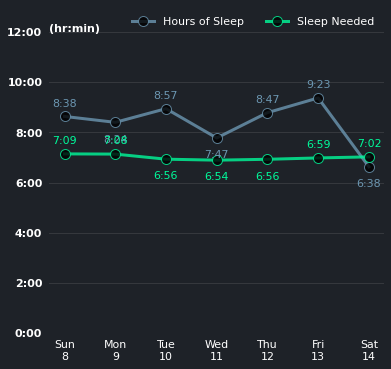

In [11]:
# this function turns a string like '2022-04-28' into 'Thu\n28'
def day_label_to_fig_label(day):
    weekday = weekdays[datetime.strptime(day, '%Y-%m-%d').weekday()]
    day_num = str(int(day.split('-')[-1]))

    return weekday + '\n' + day_num

def plot_line_fancy(X, Y, label, sleep_dur, max_sleep_time, color=None):

    plt.plot(X, Y / (60 * 60 * 1000), marker='o', markerfacecolor='black',
             markeredgewidth=1, markersize=10, linewidth=3, label=label, alpha=0.8,
             color=color)

    # add text annotations
    for i, dur in enumerate(Y):
        offset = determine_offset(i, np.array(Y), sleep_dur)
        plt.text(i, 0.6 * offset + dur / (60 * 60 * 1000) - 0.2, ms_to_text(dur).lstrip('0'),
                 ha='center', fontsize=11, color=color)

    # set to maximum y-value (in this case it is 12 hours)
    max_sleep_hours = math.ceil(max(13, max_sleep_time / 3.6e+6))
    plt.ylim(0, max_sleep_hours)

    # set the labels on the left and bottom to match the app's plot
    plt.xticks(ticks=np.arange(PLOT_LENGTH),
               labels=[day_label_to_fig_label(day) for day in X],
               fontsize=11)

    plt.yticks(ticks = list(range(max_sleep_hours + 1))[::2],
               labels = [f'{i}:00' for i in range(max_sleep_hours + 1)][::2], 
               rotation = 'horizontal',fontweight='bold', fontsize=11)

    # get rid of the little tickmarks on the bottom and side
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the left edge are off
        labelbottom=True)

with plt.style.context('dark_background'):
    sleep_dur = extracted_df['total_in_bed_time_milli'].iloc[start_idx-PLOT_LENGTH:start_idx]
    sleep_need = extracted_df['sleep_needed'].iloc[start_idx-PLOT_LENGTH:start_idx]
    day = pd.to_datetime(extracted_df['start']).dt.strftime('%Y-%m-%d').iloc[start_idx-PLOT_LENGTH:start_idx]
    sleep_dur = sleep_dur[::-1]
    sleep_need = sleep_need[::-1]
    day = day[::-1]
    # we'll use the same dark blue shade for the background color
    # throughout this plot
    background_color = '#1e2228'

    # create the figure
    plt.figure(figsize=(6,6), facecolor=background_color)
    # set background color *inside the figure*
    plt.gca().set_facecolor(color=background_color)

    # add horizontal grid
    plt.gca().grid(False)
    plt.gca().grid(axis='y', color='gray', alpha=0.3)
    plt.gca().set_axisbelow(True)

    # plot both values over time
    max_sleep_dur = max(sleep_dur)
    max_sleep_need = max(sleep_need)
    max_max = max(max_sleep_dur, max_sleep_need)
    plot_line_fancy(day, sleep_dur, 'Hours of Sleep', sleep_dur, max_max, color='#6c97b2')
    plot_line_fancy(day, sleep_need, 'Sleep Needed', sleep_dur, max_max, color='#00fb9b')

    # Insert title
    plt.text(-0.3, 12, '(hr:min)', fontsize=11, fontweight='bold')
    # insert legend
    plt.legend(facecolor=background_color,  # ensure same background color
               frameon=False,  # turn off boundaries
               ncol=2,  # arrange horizontally
               prop={'size': 11})  # set font size

    # get rid of the axis lines
    for d in ["left", "top", "bottom", "right"]:
        plt.gca().spines[d].set_visible(False)

    plt.show()

## 4.2 Sleep performance percentage weekly view
We can also plot the sleep efficiency as a bar chart.

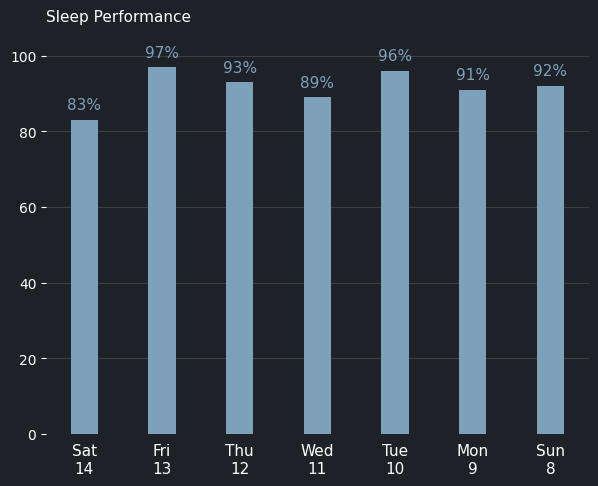

In [12]:
with plt.style.context('dark_background'):
    sleep_performance = extracted_df['sleep_performance_percentage'].iloc[start_idx-PLOT_LENGTH:start_idx]
    day = pd.to_datetime(extracted_df['start']).dt.strftime('%Y-%m-%d').iloc[start_idx-PLOT_LENGTH:start_idx]

    background_color = '#1e2228'

    plt.figure(figsize=(7,5), facecolor=background_color)
    # set background color *inside the figure*
    plt.gca().set_facecolor(color=background_color)

    # add horizontal grid
    plt.gca().grid(False)
    plt.gca().grid(axis='y', color='gray', alpha=0.3, zorder=0)
    plt.gca().set_axisbelow(True)
    # get rid of the axis lines
    for d in ["left", "top", "bottom", "right"]:
        plt.gca().spines[d].set_visible(False)

    bars = plt.bar(day, sleep_performance, width=0.35, color='#7da1ba', zorder=1)
    
    plt.xticks(ticks=np.arange(PLOT_LENGTH),
               labels=[day_label_to_fig_label(d) for d in day],
               fontsize=11)
    plt.tick_params(axis='x', which='both', bottom=False)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(round(yval, 2)) + '%', ha='center', va='bottom', color='#7da1ba', fontsize=11)
    plt.title('Sleep Performance', fontsize=11, loc='left', color='white', pad=20)

    plt.show()

# 5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1 Sleep performance v.s. total time in sleep

Maybe the sleep performance is correlated with the total time in sleep. Let us see if this hypothesis is true. We will take all the sleep performance percentages in the given time and their corresponding total time in bed. Let's make a quick plot to get some intuition. Here we just use [seaborn](https://seaborn.pydata.org/), as it's very quick to get beautiful plots out with minimal effort.

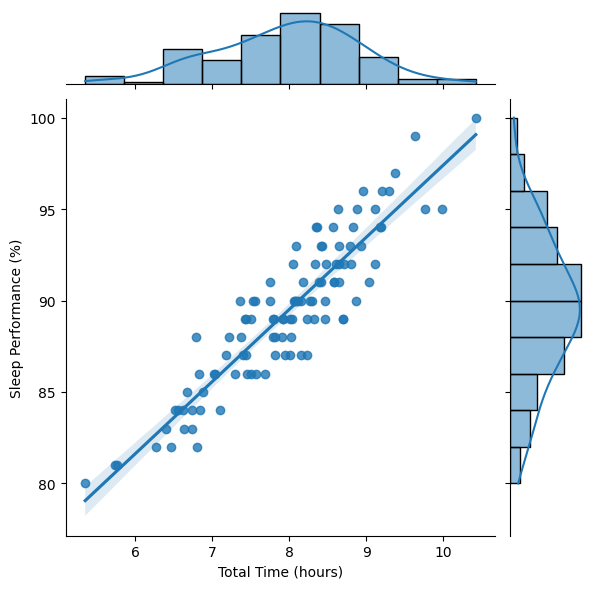

In [13]:
import seaborn as sns

sleep_performances = []
total_times = []

for index, row in sleeps_df.iterrows():
    sleep_performance = row['score']['sleep_performance_percentage']
    total_time = row['score'].get('stage_summary', {})['total_in_bed_time_milli']
    sleep_performances.append(sleep_performance)
    total_times.append(total_time)

data = {'sleep_performance_percentage': sleep_performances, 'total_in_bed_time_milli': total_times}
df = pd.DataFrame(data)
df['total_in_bed_time_hours'] = df['total_in_bed_time_milli'] / 3600000

p = sns.jointplot(x='total_in_bed_time_hours', y='sleep_performance_percentage', data=df, kind='reg')
plt.xlabel('Total Time (hours)')
plt.ylabel('Sleep Performance (%)')
plt.ylim(top=101)
plt.show()

As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [14]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_in_bed_time_hours'], df['sleep_performance_percentage'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 3.94
Coefficient of determination: 0.834
p-value: 2.05e-42


We also see that the p-value, which is determined by scipy to be the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, is significant ($<$ 0.05).

So given this evidence from this particular data, length of a sleep period is correlated with sleep performance.

## 5.2 Strain v.s. average heart rate

Let's also see if strain is correlated with heart rate. To do this, let's pull up the cycle data, and extract all the strain data along with the corresponding average heart rate of the day.

In [15]:
cycles_df = device.get_data("cycles", params=params) 
cycles_df

,user_id,id,created_at,updated_at,start,end,timezone_offset,score_state,score
0,1320,39593438,2022-06-17T00:49:26.404000Z,2022-06-17T03:29:44.095000Z,2022-06-16T00:42:50.317000Z,2022-06-16T21:50:57.404000Z,-08:00,SCORED,"{'strain': 17.7373987, 'kilojoule': 8976.222, 'average_heart_rate': 77, 'max_heart_rate': 160}"
1,1320,12569117,2022-06-16T02:25:00.317000Z,2022-06-16T04:28:22.633000Z,2022-06-15T02:56:27.157000Z,2022-06-16T00:42:50.317000Z,-08:00,SCORED,"{'strain': 17.0056305, 'kilojoule': 7900.244, 'average_heart_rate': 77, 'max_heart_rate': 159}"
2,1320,95592030,2022-06-15T04:53:07.157000Z,2022-06-15T06:23:26.929000Z,2022-06-14T08:00:00.064000Z,2022-06-15T02:56:27.157000Z,-08:00,SCORED,"{'strain': 11.0708427, 'kilojoule': 6074.834, 'average_heart_rate': 69, 'max_heart_rate': 154}"
3,1320,27122926,2022-06-13T23:10:41.371000Z,2022-06-14T01:39:47.347000Z,2022-06-13T02:42:37.064000Z,2022-06-13T21:34:40.371000Z,-08:00,SCORED,"{'strain': 10.8683659, 'kilojoule': 6165.322, 'average_heart_rate': 71, 'max_heart_rate': 177}"
4,1320,68211070,2022-06-13T05:02:20.064000Z,2022-06-13T06:34:37.261000Z,2022-06-12T08:00:00.458000Z,2022-06-13T02:42:37.064000Z,-08:00,SCORED,"{'strain': 17.4993806, 'kilojoule': 8138.781, 'average_heart_rate': 75, 'max_heart_rate': 162}"
...,...,...,...,...,...,...,...,...,...
102,1320,92952756,2022-03-07T03:08:14.902000Z,2022-03-07T05:36:06.641000Z,2022-03-06T00:36:05.728000Z,2022-03-07T01:15:28.902000Z,-08:00,SCORED,"{'strain': 12.4234311, 'kilojoule': 7382.728, 'average_heart_rate': 70, 'max_heart_rate': 170}"
103,1320,61363559,2022-03-06T02:47:09.728000Z,2022-03-06T05:15:55.010000Z,2022-03-05T06:23:07.023000Z,2022-03-06T00:36:05.728000Z,-08:00,SCORED,"{'strain': 6.4074579, 'kilojoule': 6094.724, 'average_heart_rate': 65, 'max_heart_rate': 177}"
104,1320,41009014,2022-03-05T08:36:12.023000Z,2022-03-05T09:44:27.486000Z,2022-03-04T08:00:00.551000Z,2022-03-05T06:23:07.023000Z,-08:00,SCORED,"{'strain': 10.3993208, 'kilojoule': 6182.677, 'average_heart_rate': 73, 'max_heart_rate': 176}"
105,1320,70069606,2022-03-04T00:28:53.305000Z,2022-03-04T01:48:01.273000Z,2022-03-03T03:46:56.551000Z,2022-03-03T23:06:18.305000Z,-08:00,SCORED,"{'strain': 14.2183276, 'kilojoule': 7543.387, 'average_heart_rate': 77, 'max_heart_rate': 150}"


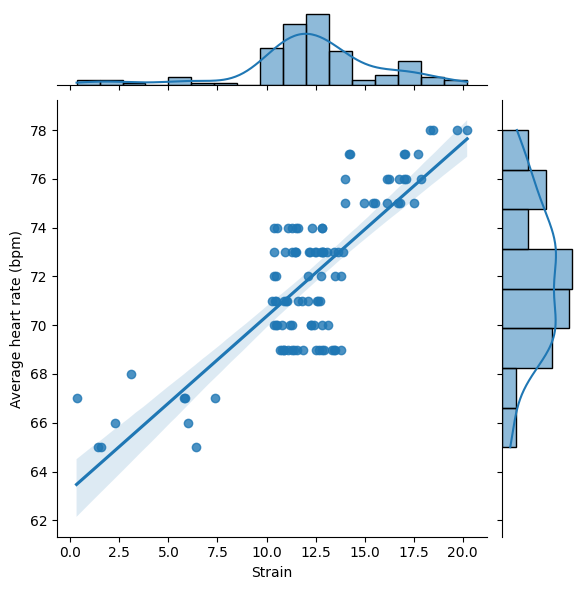

In [16]:
strains = []
hr = []
for row in cycles_df['score']:
    strains.append(row['strain'])
    hr.append(row['average_heart_rate'])


data = {'strain': strains, 'average_heart_rate': hr}
df = pd.DataFrame(data)

p = sns.jointplot(x='strain', y='average_heart_rate', data=df, kind='reg')
plt.xlabel('Strain')
plt.ylabel('Average heart rate (bpm)')

plt.show()

In [17]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['strain'], df['average_heart_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.712
Coefficient of determination: 0.652
p-value: 8.52e-26


Looks significant (<0.05)!